In [64]:
import matplotlib.image as mpimg
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from glob import glob
import cv2
#import zipfile
from PIL import Image
  
from keras.callbacks import EarlyStopping
#from keras.preprocessing import image_dataset_from_directory
#from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras import layers
from tensorflow import keras
#from layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
#from zipfile import ZipFile
  
import warnings
warnings.filterwarnings('ignore')

In [65]:
#accesing path for dataset
data_path='c:\\ZHAW\\23FS\\KI\\DataForProject'
train_path='c:\\ZHAW\\23FS\\KI\\DataForProject\\Train'

#Variables for resizing
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3
BATCH_SIZE = 32

#Getting Total Nr of Classes from Train Folder
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [66]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [67]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = train_path + "\\" + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '\\' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_test = X_train
y_test = y_train


X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)

In [69]:
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

print("X_train Type:", X_train.dtype)
print("X_valid Type", X_valid.dtype)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)
X_test.shape (27446, 32, 32, 3)
y_test.shape (27446,)
X_train Type: float32
X_valid Type float32


In [70]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CATEGORIES)

print(y_train.shape)
print(y_valid.shape)

(27446, 43)
(11763, 43)


In [71]:
IMG_SHAPE = (32, 32, 3)

In [72]:
# Create the base model from the pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               
                                               # include_top=True :Includes the fully connected layers for predictions 
                                               include_top=False,

                                               # weights from the imagenet challenge.
                                               weights='imagenet')

In [73]:
IMG_SIZE =(32,32)

In [74]:
base_model.trainable = False

In [75]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [76]:
def model():
    base_model
    return base_model

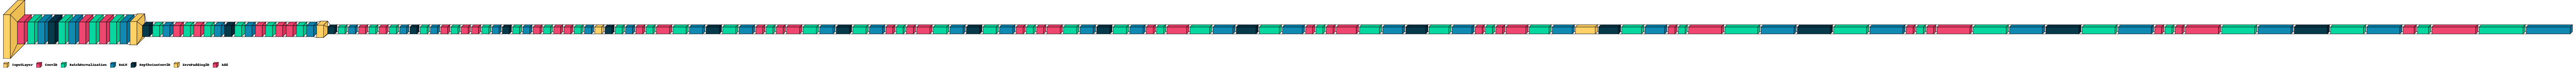

In [77]:
model1=model()
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model1, legend=True)

In [78]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [79]:
#Creating data augementation layers
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.5),
  layers.RandomZoom(.5, .2)
])

In [80]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()
prediction_layer = tf.keras.layers.Dense(43, activation="softmax")

In [82]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [83]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_17 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32, 32, 3)        0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                           

In [85]:
len(model.trainable_variables)

2

In [91]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

history = model.fit(X_train, X_valid, epochs=10, 
                    validation_data=(y_train, y_valid))

ValueError: Data cardinality is ambiguous:
  x sizes: 27446
  y sizes: 11763
Make sure all arrays contain the same number of samples.

In [86]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

NameError: name 'validation_dataset' is not defined

In [81]:
#from keras.applications.mobilenet_v2 import MobileNetV2
mobilenetV2_model = Sequential([
    data_augmentation,
    preprocess_input,
    base_model,
    global_average_layer,
    flatten_layer,
    prediction_layer
])

TypeError: The added layer must be an instance of class Layer. Received: layer=<function preprocess_input at 0x00000240A6A085E0> of type <class 'function'>.

In [ ]:
base_learning_rate = 0.0001
mobilenetV2_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
mobilenetV2_model.build(inputs)
mobilenetV2_model.summary()

TypeError: Cannot iterate over a Tensor with unknown first dimension.

In [ ]:
history = mobilenetV2_model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
511/858 [================>.............] - ETA: 35s - loss: 2.0117 - accuracy: 0.4404

KeyboardInterrupt: 